# Cell-cell communication with CellPhoneDB
This notebook outlines the steps of inference, analysis and visualization of cell-cell communication for a single-cell RNA sequencing data using **CellPhoneDB**. 

For comprehensive instructions and detailed descriptions of the methods, please refer to the official [DOCUMENTATION](https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#). CellPhoneDB was originally developed by Roser Vento-Tormo and Mirjana Efremova at the Teichmann Lab, Wellcome Sanger Institute (Cambridge, UK). From version 3 onwards, it is actively maintained and further developed by the Vento-Tormo Lab.

The source code is available on GitHub: [ventolab/CellPhoneDB](https://github.com/ventolab/CellphoneDB).

## About CellPhoneDB
CellPhoneDB is a curated repository of ligands, receptors, and their interactions. Unlike other databases, it accounts for the subunit architecture of both ligands and receptors, allowing accurate representation of heteromeric complexes. In addition to the database, CellPhoneDB includes a statistical framework that predicts enriched cell–cell interactions between pairs of cell types using single-cell transcriptomics data.

## Load the required libraries

In [2]:
import pandas as pd
import os
from cellphonedb.utils import db_utils
import anndata

## Analysis & Methods
CellPhoneDB provides three main methods for analyzing cell-cell communication, each tailored to different research scenarios. 
- The **Simple Analysis** method computes the mean expression of all ligand–receptor interactions between each pair of cell types. This approach does not involve statistical testing and is useful for initial exploratory analyses, particularly to identify interactions where both the ligand and receptor are expressed above a threshold. This method is best suited for answering the question: *What are the interactions whose ligands and receptors are expressed?*
- The **Statistical Analysis** builds upon the simple analysis by assessing whether observed mean interaction expressions are statistically significant. It does so by randomly permuting cell type labels to create a null distribution and calculating p-values for each ligand–receptor pair. This method is designed to identify interactions that are significantly enriched in a specific cell type pair compared to all others in the dataset. It is particularly suitable for general exploratory analysis where the goal is to perform a "one-versus-rest" comparison. In other words, it answers the question: *Is a particular interaction significantly more expressed in a given cell type pair compared to all other cell type pairs in the dataset?*
- The **Differential Expression Analysis** method is relevant when the research question goes beyond the “one-versus-rest” comparison. It allows users to formulate more targeted queries to identify interactions specific to particular cell types or conditions. These comparisons may include scenarios such as disease versus control, perturbed versus steady-state, or developmental and spatial gradients. In this case, the differential expression analysis is performed by the user in advance, using a method appropriate to their experimental design and research question. CellPhoneDB then identifies interactions in which at least one partner is differentially expressed in a given cell type (based on the user-provided DEG list), and the other partner is expressed in any other cell type above a specified threshold. This method is particularly useful for identifying interactions that are: *(i) specific to individual cell states within a cell type or lineage; (ii) specific to cells from a particular condition (e.g., disease vs control); (iii) associated with differentiation processes; or (iv) differentially expressed along a spatial axis*.

In this tutorial, we will focus on the **Statistical Analysis**, which corresponds to the original CellPhoneDB method.


## Data input 
The Statistical Analysis method in CellPhoneDB requires three mandatory input files:
- **counts file**: a normalized gene expression matrix.
- **metadata file**: a table linking each cell barcode to its corresponding cell type or cluster label.
- **ligand-receptor database file**: a reference file containing all putative ligand–receptor pairs used for inference.

### Counts file
The normalized gene expression matrix can be provided as .txt file (not recommended for large datasets), h5ad (recommended), h5 or a path to a folder containing a 10x output with mtx/barcode/features files.

> Important Notes: CellPhoneDB is based on **HUMAN** ligand–receptor interactions. Therefore, gene/protein IDs must be human. If working with non-human species (e.g., mouse), convert gene IDs to their corresponding HUMAN orthologs before running CellPhoneDB.

In this tutorial, we will provide a .h5ad object as the input expression matrix.

In [3]:
# inspect data
adata = anndata.read_h5ad("../../../../data_vt3/first/2306scRNAseq_HMI_Ischemic.h5ad")
adata.shape

(14961, 27416)

### Metadata file
This file is generated by the user after clustering and annotating cell types from single-cell RNA-seq data using tools such as Seurat or Scanpy.
The metadata file must contain two columns:
- 'Cell': The barcode of each cell in the experiment.
- 'cell_type': The corresponding cluster or cell type label assigned to each cell.

Accepted file formats include: .csv, .txt, .tsv, .tab, and .pickle.

In [4]:
# --Build the metadata DataFrame from the AnnData object
df = pd.DataFrame({
    'Cell': adata.obs_names,         # This gives the cell barcodes
    'cell_type': adata.obs['cell_type']  # This extracts the cell type metadata
})
print(df.head(2))

# --Save to csv
df.to_csv('cell_types_and_barcodes.csv', index=False)

                                                                  Cell  \
AAACCCAAGTATGCAA-1_2_1_1_1_1_1_1_1  AAACCCAAGTATGCAA-1_2_1_1_1_1_1_1_1   
AAACCCACAGAGAAAG-1_2_1_1_1_1_1_1_1  AAACCCACAGAGAAAG-1_2_1_1_1_1_1_1_1   

                                   cell_type  
AAACCCAAGTATGCAA-1_2_1_1_1_1_1_1_1       Fib  
AAACCCACAGAGAAAG-1_2_1_1_1_1_1_1_1       Fib  


### Download CellPhoneDB 
CellPhoneDB includes its own curated database of interactions.
Key features of CellphoneDB includes
- **Subunit architecture**: It accurately represents heteromeric protein complexes for both ligands and receptors. This is important because cell-cell communication often depends on multi-subunit complexes, going beyond simple binary ligand–receptor pairs used in many other databases.
- **Non-peptidic ligands**: The database also includes interactions involving non-peptidic molecules (i.e., molecules not encoded by genes), such as steroid hormones (e.g., estrogen). These are represented using the last enzyme in their biosynthetic pathways as a proxy for ligand abundance. This information is manually curated from literature and pathway resources like REACTOME, covering over 200 interactions involving non-peptidic ligands.
- **Human-specific**: The database only contains human interactions.

The database is organized into four main .csv files: gene_input.csv, protein_input.csv, complex_input.csv, and interaction_input.csv. To add, modify, or create a custom database, users must place these files in the same folder using the appropriate format required by CellPhoneDB. Then, the database can be generated by running the method db_utils.create_db, which will compile the inputs into a new database file  in the same directory.

In this tutorial, we will download and use the CellPhoneDB v5 database.

In [5]:
# -- Version of the databse
cpdb_version = 'v5.0.0'

# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join("cellphonedb", cpdb_version)

# -- Download database
db_utils.download_database(cpdb_target_dir, cpdb_version)

Downloaded cellphonedb.zip into cellphonedb/v5.0.0
Downloaded complex_input.csv into cellphonedb/v5.0.0
Downloaded gene_input.csv into cellphonedb/v5.0.0
Downloaded interaction_input.csv into cellphonedb/v5.0.0
Downloaded protein_input.csv into cellphonedb/v5.0.0
Downloaded uniprot_synonyms.tsv into cellphonedb/v5.0.0/sources
Downloaded transcription_factor_input.csv into cellphonedb/v5.0.0/sources


Set the paths for the database, metadata, expression counts, and output directory. These are required to run the CellPhoneDB statistical analysis.

In [6]:
# -- path to the database cellphonedb.zip
cpdb_file_path = 'cellphonedb/v5.0.0/cellphonedb.zip'
# -- path to the metadata file
meta_file_path = 'cell_types_and_barcodes.csv'
# -- paths to normalized counts file
counts_file_path = '../../../../data_vt3/first/2306scRNAseq_HMI_Ischemic.h5ad'

# -- Path to the directory where output results will be stored
output_path = 'results_cellphonedb'

## Inference of cell-cell communication

With this statistical analysis method, CellPhoneDB predicts enriched receptor–ligand interactionsbetween pairs of cell types based on scRNA-seq data. To identify the most relevant interactions between cell types, CellPhoneDB looks for the **cell-type specific interactions** between ligands and receptors.

Key Concepts:

- **Expression threshold**: Only receptors and ligands expressed in more than a user-defined proportion of cells in a cluster are tested. Default threshold: 0.1 (i.e., 10% of the cells in the cluster).
- **Multi-subunit Complexes**: For heteromeric (multi-subunit) receptors or ligands:
    - All subunits must be expressed above the threshold in the respective cluster.
    - The least expressed subunit determines the interaction’s mean expression.
    - Random shuffling and statistical testing are based on this minimum subunit expression.
- **Statistical testing**: Cluster labels are randomly permute (default: 1,000 permutations) and the mean of the average receptor expression level in a cluster and the average ligand expression level in the interacting cluster is computed. This generates a null distribution. A p-value is computed By calculating the proportion of the means which are equal or higher than the actual mean. This p-value reflects the specificity of an interaction for that particular cell-type pair.
- **Prioritization**: Interactions are ranked based on the number of significant pairs across all comparisons.

It will take a few minutes to run.

> Cell subsampling for accelerating analyses for large datasets: to improve computational efficiency, CellPhoneDB offers an option for cell subsampling using the geometric sketching approach. This method selects a representative subset of cells while preserving the transcriptomic diversity of the dataset.

In [7]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database file path.
    meta_file_path = meta_file_path,                 # mandatory: Path to metadata csv file.
    counts_file_path = counts_file_path,             # mandatory: Path to counts file, or an in-memory AnnData object
    
    # parameters
    counts_data = 'hgnc_symbol',                     # Type of gene identifiers in the counts data: "ensembl", "gene_name", "hgnc_symbol"
    iterations = 1000,                               # Denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # Minimum percentage of cells expressing the specific ligand/receptor [0.0 - 1.0]
    threads = 10,                                     # Number of threads to use in the analysis.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # A p-value below which a ligand/receptor expression mean is considered to be statistically significant. 
    
    # speed up results by subsampling
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of PCs to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).

    # save results
    separator = '|',                                 # Separator for pairs of genes (gene1|gene2) and clusters (cluster1|cluster2).
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = output_path,                       # Output path used to store the analysis results (and to store intermediate files when debugging).
    )

Reading user files...
The following user files were loaded successfully:
../../../../data_vt3/first/2306scRNAseq_HMI_Ischemic.h5ad
cell_types_and_barcodes.csv
[ ][CORE][15/07/25-09:51:16][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:-1 Threads:10 Precision:3
[ ][CORE][15/07/25-09:51:17][INFO] Running Real Analysis
[ ][CORE][15/07/25-09:51:17][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]

[ ][CORE][15/07/25-09:52:56][INFO] Building Pvalues result
[ ][CORE][15/07/25-09:52:56][INFO] Building results


Saved deconvoluted to results_cellphonedb/statistical_analysis_deconvoluted_07_15_2025_095256.txt
Saved deconvoluted_percents to results_cellphonedb/statistical_analysis_deconvoluted_percents_07_15_2025_095256.txt
Saved means to results_cellphonedb/statistical_analysis_means_07_15_2025_095256.txt
Saved pvalues to results_cellphonedb/statistical_analysis_pvalues_07_15_2025_095256.txt
Saved significant_means to results_cellphonedb/statistical_analysis_significant_means_07_15_2025_095256.txt


## Description of output files
The results from the statistical analysis will be saved to the specified output_path. All output files, except deconvoluted.txt, follow a consistent structure: rows depict interacting proteins while columns represent interacting cell type pairs.
- *id_cp_interaction*: Unique identifier for each ligand–receptor interaction in the CellPhoneDB database.
- *partner A / partner B*: IDs of the interacting partners. May have the prefix simple: (for UniProt proteins) or complex: (for multi-subunit complexes).
- *gene A / gene B*: Gene names corresponding to the interacting partners. These reflect the user’s input format (e.g., Ensembl IDs or gene symbols).
- *secreted*: True if either partner is a secreted molecule.
- *receptor A / receptor B*: True if the respective partner is annotated as a receptor.
- *annotation_strategy*: Indicates whether the interaction was manually curated (curated) or imported from an external database.
- *is_integrin*: True if one of the interacting partners is an integrin.
- *directionality*: Indicates the direction of the interaction, useful for understanding signaling flow.
- *classification*: Biological pathway or signaling classification of the interacting partners.
- *interacting_pair*: Combined name of the interaction in the format geneA|geneB.


The values contained in each output file generated by the statistical_analysis method of CellPhoneDB differ according to the file’s purpose:
- The “**means.txt**” file contains mean values for each ligand-receptor interaction (rows) for each cell-cell interaction pair (columns).
- The “**pvalues.txt**” contains the P values for the likelihood of cell-type specificity of a given receptor–ligand complex (rows) in each cell-cell interaction pair (columns), resulting from the statistical_analysis.
- The “**significant_means.txt**” contains the mean expression (same as “means.txt”) of the significant receptor–ligand complex only. This is the result of crossing “means.csv” and “pvalues.txt”. If p.value < 0.05, the value will be the mean. Alternatively, the value is set to NaN. Also includes a rank column, indicating the number of significant comparisons for each interaction, normalized by the total number of cell–cell comparisons.
- The “**deconvoluted.txt**” and “**percentages.txt**” files give additional information for each of the interacting partners. 


In [8]:
cpdb_results['means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,PC|vSMCs,vSMCs|Adipo,vSMCs|CM,vSMCs|Endo,vSMCs|Fib,vSMCs|Lymphoid,vSMCs|Mast,vSMCs|Myeloid,vSMCs|PC,vSMCs|vSMCs
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,...,0.014,0.033,0.015,0.029,0.016,0.007,0.008,0.01,0.006,0.016
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000


In [9]:
cpdb_results['pvalues'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,PC|vSMCs,vSMCs|Adipo,vSMCs|CM,vSMCs|Endo,vSMCs|Fib,vSMCs|Lymphoid,vSMCs|Mast,vSMCs|Myeloid,vSMCs|PC,vSMCs|vSMCs
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
cpdb_results['significant_means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,PC|vSMCs,vSMCs|Adipo,vSMCs|CM,vSMCs|Endo,vSMCs|Fib,vSMCs|Lymphoid,vSMCs|Mast,vSMCs|Myeloid,vSMCs|PC,vSMCs|vSMCs
50,CPI-SS00C24ED50,CDH5_CDH5,simple:P33151,simple:P33151,CDH5,CDH5,False,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,CPI-CS0F721837F,ProstaglandinE2_byPTGES2_PTGER3,complex:ProstaglandinE2_byPTGES2,simple:P43115,NaN,PTGER3,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Interpreting and visualizing the outputs
The key output file from CellPhoneDB's statistical analysis is **significant_means.txt** and the user can prioritize interactions that have low p-values (high statistical significance) and/or  high mean expression values (strong signal).

### Querying interactions

CellphoneDB results can be queried by making use of the search_analysis_results method. This method requires two of the files generated by CellphoneDB: **significant_means** and **deconvoluted**.
Users can define specific filters to extract interactions of interest, including: 
- the cell type involved in the interaction 
- the genes participating in the receptor–ligand pair
- the name of the interaction
- its functional classification
- minimum interaction score across the selected cell types.

Now let's perform a query to find specific interactions of interest.
In this example, we are going to filter interactions in which Fibroblasts interact with Cardiomyocytes. Furthermore, we will select those interactions in which the gene TGFB1 participates.

In [11]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    # filtering criteria 
    query_cell_types_1 = ['Fib'],                                       # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['CM'],                                        # List of cells 2, will be paired to cells 1 (list or 'All').
    query_genes = ['TGFB1'],                                             # filter interactions based on the genes participating (list).     
    query_classifications = ['Signaling by Fibroblast growth factor'],  # filter intereactions based on their classification (list).
    query_interactions = None,                                          # filter intereactions based on their name (list).
    query_minimum_score = 50,                                           # minimum score that an interaction must have to be filtered.
   
    # output files
    significant_means = cpdb_results['significant_means'],              # significant_means file generated by CellphoneDB.
    deconvoluted = cpdb_results['deconvoluted'],                        # devonvoluted file generated by CellphoneDB.

    separator = '|',                                                    # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True,                                                 # converts the output into a wide table, removing non-significant interactions
)

search_results.sort_values(by='significant_mean', ascending=False).head(50)


,interacting_pair,partner_a,partner_b,gene_a,gene_b,directionality,classification,interacting_cells,significant_mean
1,NCAM1_FGFR1,simple:P13591,simple:P11362,NCAM1,FGFR1,Ligand-Receptor,Signaling by Fibroblast growth factor,CM|Fib,0.744
0,FGF1_FGFR1,simple:P05230,simple:P11362,FGF1,FGFR1,Ligand-Receptor,Signaling by Fibroblast growth factor,CM|Fib,0.244
5,TGFB1_TGFbeta_receptor2,simple:P01137,complex:TGFbeta_receptor2,TGFB1,NaN,Ligand-Receptor,Signaling by Transforming growth factor,Fib|CM,0.168


### Basic analysis and plotting: ktplotspy
Ktplotspy is a python library to help visualize CellPhoneDB results, ported from the original ktplots R package

In [12]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

**Heatmap of Significant Interactions**:
This heatmap displays the number of significant ligand-receptor interactions (p-value < 0.01) between each pair of cell types, based on CellPhoneDB output.

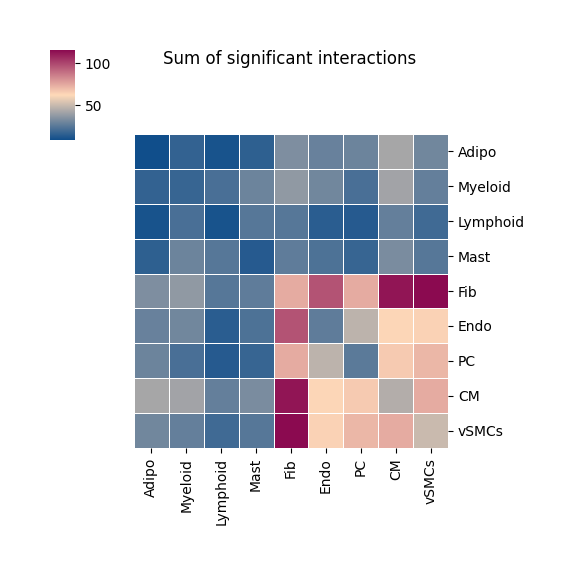

In [13]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['pvalues'],                  # Dataframe corresponding to `pvalues.txt`
                      alpha = 0.01,                                     # pvalue threshold value for significance.
                      row_cluster = True,                               # Whether to cluster rows.
                      col_cluster = True,                               # Whether to cluster columns.
                      title = "Sum of significant interactions",        # Title of the heatmap plot
                      figsize=(5, 5))                                   # Figure size in inches


You can specify particular cell types to include in the plot using the cell_types argument.
> By default, the heatmap is symmetrical, meaning it does not consider the direction of communication between cell types. That is, interactions are treated as bidirectional:
celltypeA ↔ celltypeB.

If you set symmetrical=False, the heatmap reflects the directionality of ligand–receptor interactions, i.e. moleculeA (ligand) expressed by celltypeA → moleculeB (receptor) expressed by celltypeB
Important: 
- The y-axis represents the source/sender cell type (producing the ligand). 
- The x-axis represents the target/receiver cell type (expressing the receptor).

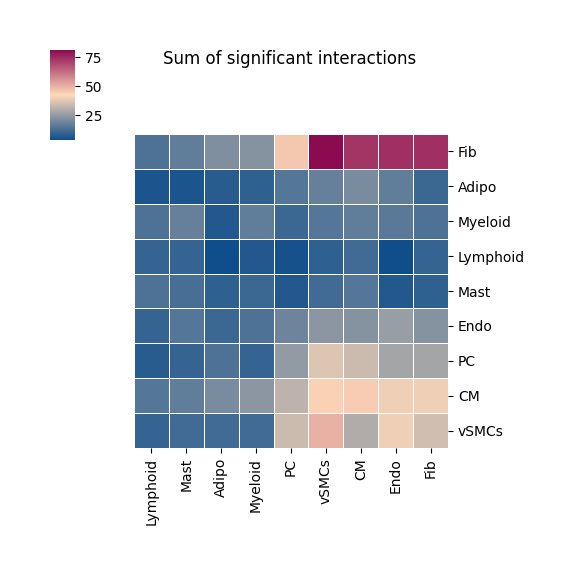

In [14]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['pvalues'],                  # Dataframe corresponding to `pvalues.txt`
                      alpha = 0.01,                                     # pvalue threshold value for significance.
                      row_cluster = True,                               # Whether to cluster rows.
                      col_cluster = True,                               # Whether to cluster columns.
                      title = "Sum of significant interactions",        # Title of the heatmap plot
                      figsize=(5, 5),                                   # Figure size in inches
                      
                      symmetrical=False)                                # Whether to return the sum of interactions as symmetrical heatmap.

When running `plot_cpdb_heatmap` with the return_tables=True option, the user can retrieve the dataframes that store the numerical values underlying the heatmap visualization. 
Specifically, the output includes the following:
- 'count_network': A square matrix (cell types × cell types) showing the number of significant interactions for each source–target pair. Rows represent target cell types (receivers), and columns represent source cell types (senders).
- 'interaction_count': A summary table that provides the total number of interactions per cell type. The row values correspond to the total number of interactions where the cell type acts as the sender (ligand-producing), and the column values represent interactions where the cell type is the receiver (receptor-expressing).
- 'interaction_edges': A long-format dataframe listing each source (sender) and target (receiver) cell type pair, along with the number of interactions between them. This format is ideal for network and edge-based visualizations.


In [15]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['pvalues'],                  # Dataframe corresponding to `pvalues.txt`
                      alpha = 0.01,                                     # Significance threshold for interactions (p-value cutoff)
                      row_cluster = True,                               # Whether to cluster rows.
                      col_cluster = True,                               # Whether to cluster columns.
                      title = "Sum of significant interactions",        # Title of the heatmap plot
                      figsize=(5, 5),                                   # Figure size in inches
                      symmetrical=False,                                # Whether to return the sum of interactions as symmetrical heatmap.

                      return_tables = True)                             # Whether to return the dataframes storing the interaction network.

{'count_network':           Adipo    CM  Endo   Fib  Lymphoid  Mast  Myeloid    PC  vSMCs
 Adipo       8.0  21.0  11.0  22.0       4.0   9.0      7.0  14.0   12.0
 CM         21.0  45.0  23.0  73.0      12.0  15.0     17.0  34.0   30.0
 Endo       17.0  40.0  26.0  74.0       4.0   7.0     16.0  28.0   40.0
 Fib        11.0  40.0  23.0  74.0      10.0   9.0     14.0  28.0   35.0
 Lymphoid    6.0  15.0  10.0  14.0      10.0  14.0     14.0   8.0   10.0
 Mast        6.0  17.0  15.0  17.0      10.0  13.0     18.0  10.0   12.0
 Myeloid     9.0  24.0  14.0  23.0       7.0  11.0     17.0  10.0   12.0
 PC         15.0  32.0  19.0  46.0       5.0   7.0     11.0  25.0   34.0
 vSMCs      18.0  44.0  24.0  81.0       9.0  12.0     15.0  37.0   50.0,
 'interaction_count':           total_interactions_row  total_interactions_col
 Adipo                      111.0                   108.0
 CM                         278.0                   270.0
 Endo                       165.0                   252.0

**Dot Plot of Specific Ligand–Receptor Interactions**: DotPlots are a powerful way to visualize specific ligand–receptor interactions that are statistically significant between pairs of cell types. They simultaneously display the strength (mean expression) and significance (p-value) of interactions, helping to highlight key communication in your dataset.

For example, here we focus on interactions involving Fibroblasts (Fib) and molecules SPP1, TGFB1, and COL1A1.

In [16]:
pip show plotnine

/project/.pixi/envs/default/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


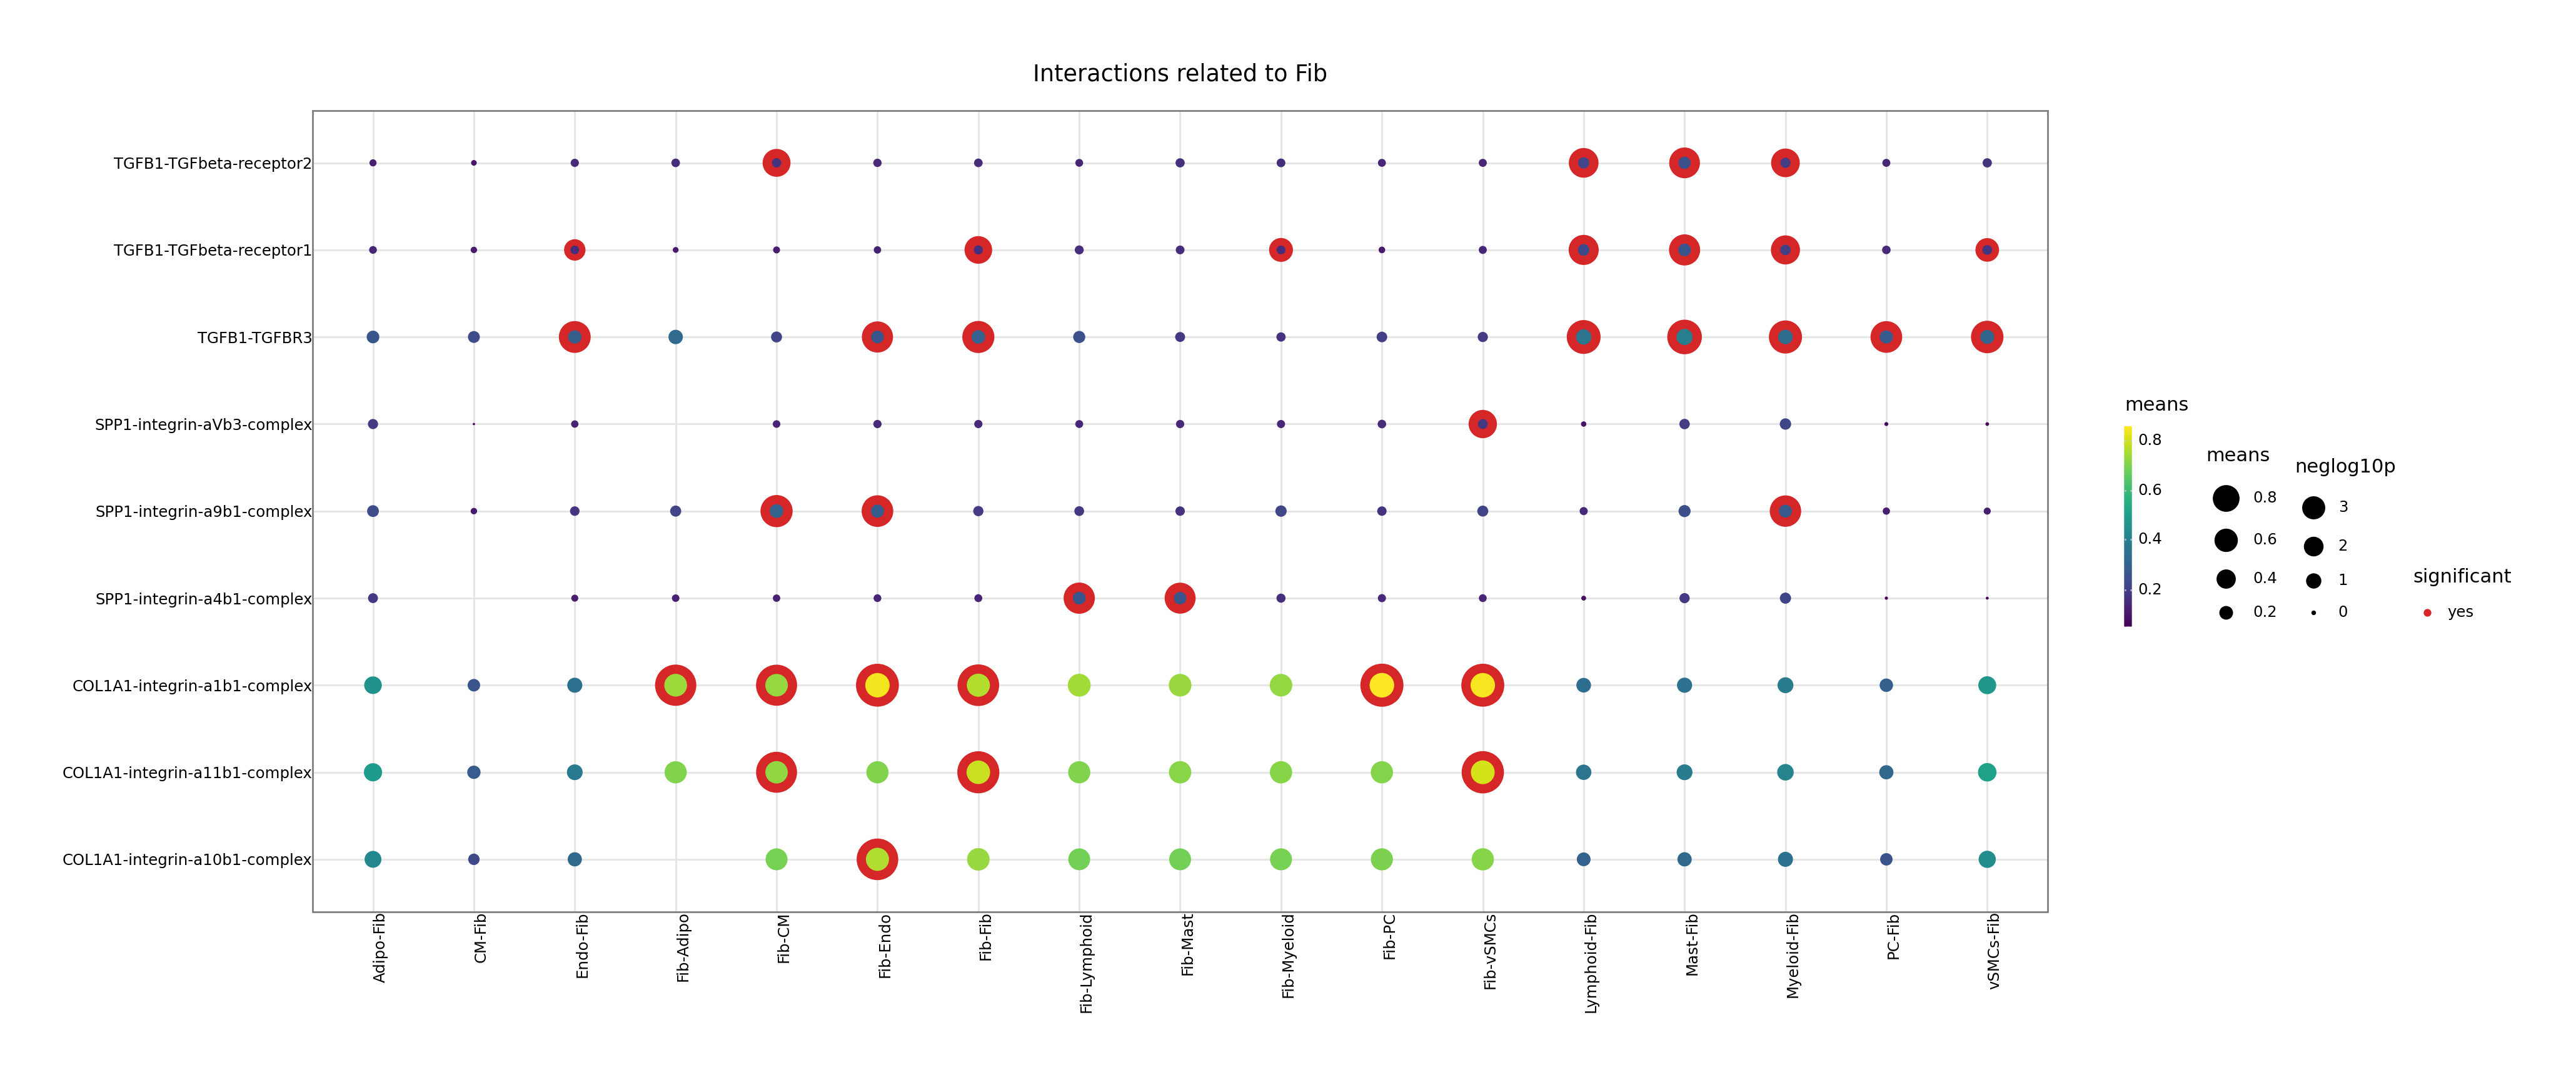

In [17]:
kpy.plot_cpdb(
    adata = adata,                                        # `AnnData` object
    means = cpdb_results['means'],                        # Data frame corresponding to `means.txt` from CellPhoneDB.
    pvals = cpdb_results['pvalues'],                      # Data frame corresponding to `pvalues.txt` from CellPhoneDB.
    celltype_key = "cell_type",                           # Column name in `adata.obs` storing the celltype annotations.

    # subset the data
    cell_type1 = "Fib",                                   # Name of cell type 1            
    cell_type2 = ".",                                     # Name of cell type 2. "." means all cell-types
    genes = ['SPP1', 'TGFB1', 'COL1A1'],                  # plot only interactions containing the specified gene(s).
    cluster_rows= True,                                   # Whether or not to cluster the rows (interactions).

    figsize = (20, 8),                                    # Figure size in inches
    title = "Interactions related to Fib",                # Title of the heatmap plot
    standard_scale = False,                               # Whether or not to scale the mean interaction values from 0 to 1 per receptor-ligand variable.
)



**CHORD DIAGRAM of specific interactions**: A chord diagram (also called a circos plot) is a powerful way to visualize complex interactions between cell types, showing directional communication as arcs connecting cell type sectors arranged in a circle. The thickness of the chords represents the strength of interactions.
The chord diagram is implemented using the pyCirclize package, providing a flexible and customizable alternative to the original R-based circos visualization.

Here, we specifically highlight cell–cell communication that involves the ligand TGFB1, allowing us to explore how this key receptor mediates signaling across different cell types.

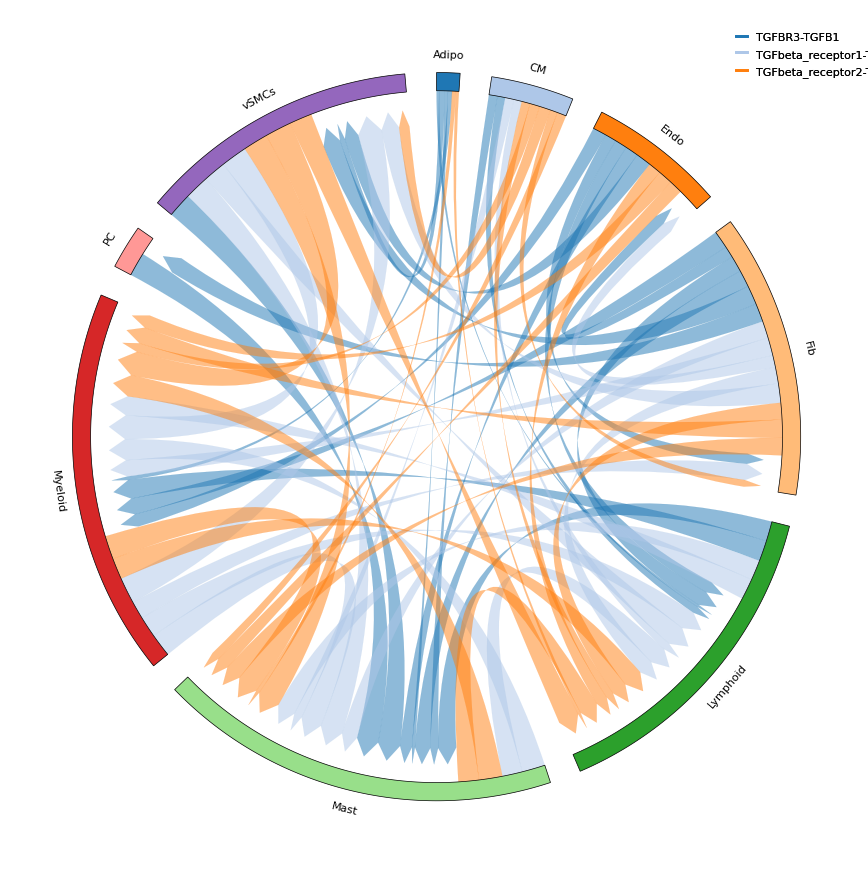

In [18]:
kpy.plot_cpdb_chord(
    adata = adata,                                        # `AnnData` object
    means = cpdb_results['means'],                        # Data frame corresponding to `means.txt` from CellPhoneDB.
    pvals = cpdb_results['pvalues'],                      # Data frame corresponding to `pvalues.txt` from CellPhoneDB.
    celltype_key = "cell_type",                           # Column name in `adata.obs` storing the celltype annotations.
    deconvoluted= cpdb_results['deconvoluted'],           # Dataframe corresponding to `deconvoluted.txt` from cellphonedb.

    # subset the data
    cell_type1 = ".",                                     # Name of cell type 1.  "." means all cell-types          
    cell_type2 = ".",                                     # Name of cell type 2. "." means all cell-types
    interaction= ["TGFB1"]                                # Interaction(s) to plot. If None, all interactions will be plotted.
)

# Unexplored feature
- **Interaction ranking**:
CellPhoneDB v5 introduces a scoring method that ranks interactions based on the specificity of interacting partners. It scales mean gene expression across cell types from 0 to 10 and calculates the product of scaled mean expressions of interacting proteins as a proxy for interaction relevance.
Note: This scoring differs from interaction inference, so some significant interactions may have low scores, and vice versa. To enable scoring, use score_interactions=True in the main function. Scores are returned in interaction_scores_dict.

- **Spatial Information / Microenvironments**:
CellPhoneDB can prioritize interactions occurring between neighboring cell types. To enable this functionality, the user must provide a file with two columns specifying which cell type is associated with which spatial microenvironment. The tool will restrict tested cell–cell interactions to those occurring within the same microenvironment (i.e., it will only test combinations of clusters that coexist in a given spatial context).

- **CellSign**:
A module designed to prioritize ligand–receptor interactions that are supported by the activation of downstream, directly regulated transcription factors (TFs). CellSign is accompanied by a curated collection of 211 well-characterized receptor–TF direct regulatory relationships, integrated into the CellPhoneDB database. This module requires a user-provided list of active TFs in each cell type, ideally inferred in a data-driven manner from high-throughput epigenomic or transcriptomic data.

- **CellPhoneDBViz**:
A visualization tool for displaying the results of differential or statistical analyses performed using the CellPhoneDB package (version ≥ 4.0.0). It enables intuitive exploration and presentation of cell–cell interaction data.

# Citation


- **CellphoneDB v1 (original)**: *Single-cell reconstruction of the early maternal-fetal interface in humans. Vento-Tormo R, Efremova M, et al., Nature. 2018*
- **CellphoneDB v2**: *Inferring cell-cell communication from combined expression of multi-subunit receptor-ligand complexes. Efremova M, Vento-Tormo M, Teichmann S, Vento-Tormo R. Nat Protoc. 2020*
- **CellphoneDB v3**: *Mapping the temporal and spatial dynamics of the human endometrium in vivo and in vitro. L Garcia-Alonso, L-François Handfield, K Roberts, K Nikolakopoulou et al. Nature Genetics 2021*
- **CellphoneDB v4**: *Single-cell roadmap of human gonadal development. L Garcia-Alonso, V Lorenzi et al. Nature, 2022* 
- **CellphoneDB v5 (latest)**: *CellphoneDB v5: inferring cell-cell communication from single-cell multiomics data, Troule et al., Nature Protocls, 2023*
